### Simulates transitions between biome types in a haphazard way


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
class all_params:
    """
    """
    def __init__(self, update ={}, veg_type = "meadow"):

            
        veg_dict = {
                "conifer" :  {
                    "alpha" : 0.05,                 
                    "k_u" : 20.6, 
                    "k_l" : 1.2,
                    "r_u" : 0.25,
                    "r_l" : 1.5,               
                    "beta" : 0.5,
                    "chi" : 1,
                    "psi_u" : 0.8,
                    "psi_l" : 0.,                
                    "gamma_l" : 0.5,
                    "gamma_u" : 0.5
                    },
                "meadow" :  {
                    "alpha" : 0.05,        
                    "k_u" : 3.14,
                    "r_u" : 0.1,               
                    "chi" : 1,
                    "beta" : 0.5,
                    "tau" : 100,
                    },
                "grass" :  {
                    "alpha" : 0.05,
                    "k_u" : 3.14,
                    "r_u" : 0.1,               
                    "gamma" : 0.5,
                    "chi" : 1,
                    "beta" : 0.5,
                    "gamma_u" : 1,
                    "psi_u" : 0.8,
                    "tau" : 100                    
                    },
                "shrub" :  {
                    "alpha" : 0.05,
                    "k_u" : 3.14,
                    "r_u" : 0.1,               
                    "chi" : 1,
                    "beta" : 0.5,
                    "gamma_u" : 0.1,
                    "psi_u" : 0.8,
                    "tau" : 100
                } 
            }
        
        params = veg_dict[veg_type]
        params["veg_type"] = veg_type
        params.update(update)
        
        for k, v in params.items():
            setattr(self, k, v)
        
    def __repr__(self):
        attrs = vars(self)
        return  '{' + ',\n  '.join("%s: %s" % item for item in attrs.items()) +'}'                


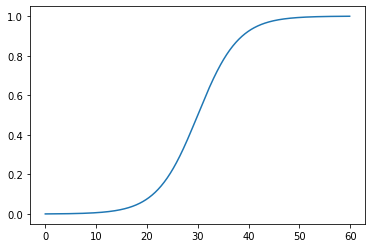

In [4]:
# succession
years_since_fire = np.arange(0, 60., 0.1)
y = (years_since_fire- 60/2.)/4.
threshold =  1/(1 + np.e**-(y))
plt.plot(years_since_fire, threshold)

In [5]:
class RCSR:
    """
    Assumptions:
        fuel is proportional to living vegetation  
        fuel moisture is proportional to soil moisture
        
    """
    
    def __init__(self, params = {}):
        """
        State variables:
            R_u, R_l : burning biomass
            G_u, G_l : green biomass
        
            
        Forcing:
            alpha : accounrts for the competition between species
            beta : parameter that quantifies vegetation drought tolerance            
            k_u, k_l : carrying capacities        
            P  : mean annual soil moisture income            
            r_u, r_l : specfic growth rates
        """ 
        self.G_u_list = []
        self.G_l_list = []
        self.fire_list = []
        self.S_list = []        
        self.succession_list = []         

        self.veg_list = []
        self.t = 0
        self.time_past_fire = 0
        self.cat_severity = 0
        self.fires = 0
        conifer = all_params(params, veg_type = "conifer") 
        meadow = all_params(params, veg_type = "meadow")         
        shrub = all_params(params, veg_type = "shrub")         
        grass = all_params(params, veg_type = "grass")         
                
        defaults =  {
            "P" : 300,
            "G_u" : 0.1,
            "G_l" : 0.4,
            "S" : 0.4,
            "K_s" : 400,
            "H" : 800,
            "n" : 0.4,
            "spin" : 0.,
            "tmax" : 4000,
            "initial_veg" : "conifer",
            "extinct" : False,
            "dt" : 1,
            "minP" : 0.95
        } 
        
        defaults.update(params)
        
        for k, v in (defaults).items():
            setattr(self, k, v)
            
        inits = all_params(params, defaults["initial_veg"])
        
        for k, v in vars(inits).items():
            setattr(self, k, v)
                
        self.param_dict = {"conifer": conifer,
                           "meadow" : meadow,
                           "grass" : grass,
                           "shrub" : shrub,
                          }
        
        self.times = np.arange(0, self.tmax + self.dt, self.dt)
        self.ti = np.where(self.times > self.spin)[0][0]
        self.nt_steps = len(self.times)       

        if self.K_s < self.P:
            self.K_s = self.P
            
        self.transition_probs = {"conifer" : {
                                    "meadow": [0, 0.2],
                                    "grass" : [0.2, 0.3],
                                    "shrub" : [0.3, 0.4],
                                    "conifer" :[0.4, 1]},
                                "grass" :                                 
                                    {"grass" :[0.0, 0.75],
                                    "shrub" :[0.75, 1]},
                                "shrub" :                                 
                                    {"shrub" :[0.0, 0.75],
                                    "conifer" :[0.75, 1]}
                                }
       
                  
    def __repr__(self):
        
        attrs = vars(self)
        return  '{' + ',\n  '.join("%s: %s" % item for item in attrs.items()) +'}'                
    
    def g_u(self):
        """
        Upper layer growth rate
        """
        return self.r_u*self.G_u*(1-self.G_u/self.k_u)*self.f_S()
        
    def g_l(self):
        """
        Lower layer growth rate
        """
        g_l = self.r_l*self.G_l*(1-self.G_l/self.k_l)*self.f_S()-self.alpha*self.G_l*self.G_u
        return g_l

    
    def f_S(self):
        """
        vegetation growth limiting factor        
        """        
        return self.S**self.beta
    
    def h_S(self):
        """
        fire severity decreases with increasing soil moisture
        """
    
        return (1-self.S)**self.chi
        
    def derivs(self):
        
        if self.veg_type == "conifer":
            
            self.G_u_dot = self.g_u()  
            self.G_l_dot = self.g_l()   
            
        else:    
            self.G_u_dot = self.g_u() 

        
    def Gaby_soil(self):
        """
        what happens when :
            shrub changes to conifer?
            sparse (grass) changes to shrub?
        """  
        Co = {"conifer": {
                "grass" : 0.19, "conifer" : 0.21,"shrub" :0.22, "meadow" :0.40 },
              "meadow": {
                "grass" : np.nan, "conifer" : 0.25,"shrub" :  np.nan, "meadow" : 0.52 },
              "shrub": {
                "grass" : np.nan, "conifer" : 0.2, "shrub" : 0.2, "meadow" : np.nan },
              "grass": {
                "grass" : 0.21, "conifer" : 0.21, "shrub" : 0.21, "meadow" : np.nan },

             }
        S_dict = Co[self.initial_veg]
        S = S_dict[self.veg_type]
                       
        self.S  = S
        
    
        if self.cat_severity > 0:
            self.S -= 0.04
        if self.fires == 1:
            self.S += 0.04
        elif self.fires>1:
            self.S += 0.02
                    
    def transition(self):
        """
        transition to new veg type after fire
        """
        threshold = self.transition_probs[self.veg_type]
        
        initial_veg = self.veg_type
        m = self.transition_probs[initial_veg]
        random_num = np.random.rand()
        
        for key in m.keys():
            pmin, pmax = m[key]

            if (random_num >= pmin) and (random_num < pmax):
                final_veg = key
                break
            else:
                continue
        
        if final_veg != initial_veg:
            
            params = self.param_dict[final_veg]

            for k, v in vars(params).items():
                setattr(self, k, v)
        
            
            self.veg_type = final_veg
            self.initial_veg = initial_veg
            self.succession_list.append([self.t, self.time_past_fire, 
                                         "{0}--{1}".format(initial_veg, final_veg), ""])
            
    def succession(self):
        """
        function of time 
        """

        veg_type = self.veg_type

        y = (self.time_past_fire - self.tau/2.)/2.
        threshold =  1/(1 + np.e**-(y))
        
        rand_number = np.random.rand()

        if rand_number < threshold:   
            
            if veg_type == "meadow":            
            
                params = self.param_dict["conifer"]

                for k, v in vars(params).items():
                    setattr(self, k, v)
        
                self.veg_type = "conifer"            
                self.succession_list.append([self.t, self.time_past_fire, "",
                                             "meadow->conifer"])

            elif veg_type == "grass" : 
            
                params = self.param_dict["shrub"]

                for k, v in vars(params).items():
                    setattr(self, k, v)
        
                self.veg_type = "shrub"            
                self.succession_list.append([self.t, self.time_past_fire, "", "grass->shrub"])
                
            elif veg_type == "shrub" : 
                
                params = self.param_dict["conifer"]
                    
                for k, v in vars(params).items():
                    setattr(self, k, v)
        
                self.veg_type = "conifer"            
                self.succession_list.append([self.t, self.time_past_fire,"", "grass->shrub"])
            print (self.veg_type)
            
    def ignite_threshold(self, S):
        """
        """    
        threshold = self.minP + S*(1-self.minP)
        
        return threshold
    
    def ignition(self):
        
        u_ignite = np.random.rand()
        threshold = self.ignite_threshold(self.S)

        if u_ignite > threshold:            
            u_severity = self.severity_function(self.S, self.G_u, "upper")
        else:
            u_severity = 0.0
            
        l_ignite = np.random.rand()
        if (self.veg_type == "conifer") & (l_ignite > threshold):
            l_severity = self.severity_function(self.S, self.G_l, "lower")
        else:
            l_severity = 0.0
            
        return u_severity, l_severity
    
    def severity_threshold(self, severity):
        """
        """
        if severity < 0.33:
            return 0
        elif severity < 0.66:
            return 1
        else:
            return 2
             
    def severity_function(self, S, G, layer):
        """
        """    
        soil_factor = self.soil_factor(S)
        
        if layer == "lower":
            biomass_factor = self.l_biomass_factor(G)
        else:
            biomass_factor = self.u_biomass_factor(G)
        
        severity = biomass_factor*soil_factor
        
        try:
            if severity > 0.99:
                severity = 0.99
        except:
            severity[severity>0.99] = 0.99

        return severity
    

    def soil_factor(self, S):
        """
        fire severity decreases with increasing soil moisture
        """
        y = (- S + .2)/self.chi
        # 1/(1 + np.e**(-y)) #(1-S)**self.chi
        return  np.ones_like(S)

    def u_biomass_factor(self, G): 
        """
        fire severity increases with increasing biomass
        """
        y = (G - self.k_u*self.psi_u)
        biomass_factor =  1/(1 + np.e**(-y/self.gamma_u))
        return biomass_factor

    def l_biomass_factor(self, G): 
        """
        fire severity increases with increasing biomass
        """
        y = (G - self.k_l*self.psi_l)
        biomass_factor =  1/(1 + np.e**(-y/self.gamma_l))
        return   biomass_factor    # self.gamma_l + (0.9-self.gamma_l)*G/self.k_l
      
    
    def timestep(self):
        """
        """
        self.derivs()
        
        G_u = self.G_u + self.G_u_dot*self.dt
         
        if self.veg_type == "conifer":
            G_l = self.G_l + self.G_l_dot*self.dt                    
        else:
            G_l = 0

        self.G_l = max(1e-7, G_l)
        self.G_u = max(1e-7, G_u)
        
        self.Gaby_soil()
        
        if self.veg_type == "meadow":
            u_severity, l_severity = 0.0, 0.0    
        else:
            u_severity, l_severity = self.ignition()
            
        
        if  l_severity > 1e-5:    
            u_to_l = min(np.random.rand(), l_severity)                    
            G_l = self.G_l*(1 - l_severity - u_severity*u_to_l)
            lower_fire = True
        else:
            G_l = self.G_l
            lower_fire = False            
            
  
        if u_severity > 1e-5:
            
            l_to_u = min(np.random.rand(), u_severity)
            G_u = self.G_u*(1 - u_severity - l_severity*l_to_u)
            upper_fire = True
            self.cat_severity = self.severity_threshold(u_severity)
                  
        else:
            G_u = self.G_u
            upper_fire = False
            
        if (u_severity > 1e-5) or (l_severity > 1e-5):  
            
            initial_biomass = self.G_l + self.G_u
            final_biomass = G_l + G_u      
                    
                
            self.fire_list.append([self.t, 
                                   self.veg_type,
                                   upper_fire,
                                   (G_u - self.G_u)/self.G_u*100,                                   
                                   lower_fire,
                                   (G_l - self.G_l)/self.G_l*100,
                                   (final_biomass - initial_biomass)/initial_biomass*100,
                                   final_biomass])
    
        self.G_l = G_l
        self.G_u = G_u

        if self.veg_type != "conifer":             
            self.succession()
            
        self.G_u_list.append(self.G_u)
        self.G_l_list.append(self.G_l)
        self.S_list.append(self.S)
        
        self.t = self.t + self.dt
        self.veg_list.append(self.veg_type)        
        
        if u_severity:
            
            self.time_past_fire = 0
            self.fires += 1
            self.transition()
        else:
            self.time_past_fire = self.time_past_fire + self.dt
   
    def check_for_large_vals(self):
        for key, var  in vars(p).items():
            if type(var) == float and key not in ["time_past_fire", "t"]:
                if abs(var) >1e3:
                    print(key, var)
                    return True
        
    def run(self):
        
        for i in range(self.nt_steps):
            self.timestep()
            if self.check_for_large_vals():
                break
            
        self.G_u_list = np.array(self.G_u_list)
        self.veg_list = np.array(self.veg_list)
        

In [6]:
S = np.arange(0., 1, 0.01)
param = {
              "chi" : 1,
               "tmax" : 1000,
               "dt" : 1,
               "beta" :  0.5,
               "initial_veg" : "conifer"     
             }

p = RCSR(param)


Text(0.5, 0, 'Soil moisture')

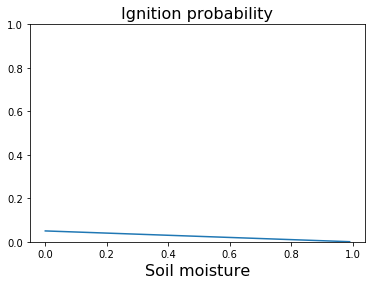

In [7]:

plt.plot(S, 1- p.ignite_threshold(S))
plt.ylim(0, 1)
plt.title("Ignition probability",fontsize = 16)
plt.xlabel("Soil moisture",fontsize = 16)


In [8]:
p = RCSR(param)

In [9]:
p.run()

conifer
conifer
conifer
conifer


In [10]:
pd.DataFrame(p.succession_list, columns=["year", "years since fire", "transition", "succession"]).sort_values(by = "year")


,year,years since fire,transition,succession
0,74,0,conifer--meadow,
1,125,51,,meadow->conifer
2,478,0,conifer--shrub,
3,537,48,,grass->shrub
4,577,0,conifer--meadow,
5,628,51,,meadow->conifer
6,693,0,conifer--meadow,
7,735,42,,meadow->conifer
8,940,0,conifer--shrub,
9,957,0,shrub--conifer,


In [11]:
import pandas as pd
df = pd.DataFrame(p.fire_list, columns = [ "year", "veg", "upper", "% change", "lower", \
                                          "% change", "both", "initial"]).round(2)
df.head()


,year,veg,upper,% change,lower,% change,both,initial
0,19,conifer,False,0.0,True,-90.59,-48.41,1.09
1,28,conifer,False,0.0,True,-88.32,-24.50,2.75
2,51,conifer,False,0.0,True,-61.40,-0.95,14.81
3,73,conifer,True,-99.0,False,0.00,-98.99,0.20
4,137,conifer,False,0.0,True,-50.00,-0.00,5.69


Text(0.5, 1.0, 'biomass')

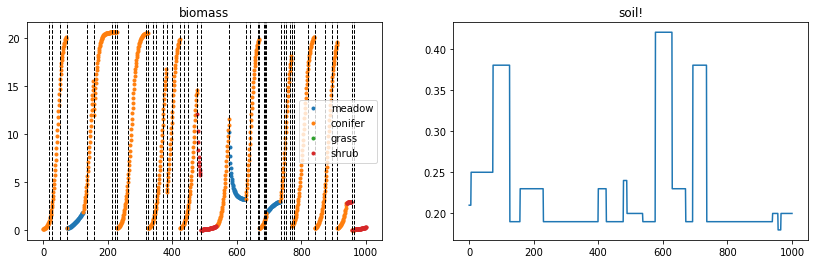

In [12]:

m_inds = np.where(np.array(p.veg_list ) == "meadow")[0]
c_inds = np.where(np.array(p.veg_list ) == "conifer")[0]

g_inds = np.where(np.array(p.veg_list ) == "grass")[0]
s_inds = np.where(np.array(p.veg_list ) == "shrub")[0]


fig, axes = plt.subplots(1,2, figsize = (14,4) )
sims = []

ind_order = ["meadow", "conifer", "grass", "shrub"]

for i, inds in enumerate([m_inds, c_inds, g_inds, s_inds ]):
    axes[0].plot(p.times[inds],np.array( p.G_u_list[inds]), '.',
                 label = ind_order[i])        
    
for i in range(len(df)):
    axes[0].axvline(df.iloc[i].year, lw = 1, ls = "--", c = "k")
axes[0].legend()

axes[1].plot(p.times,np.array( p.S_list), '-', ms= 5, 
             label = "meadow")        
     
axes[1].set_title("soil!")
axes[0].set_title("biomass")

